###  Baseline Pruned Model Trained on SNLI and Tested on SNLI
sources used:
* https://arxiv.org/pdf/2004.03844
* https://www.tensorflow.org/tutorials/customization/custom_layer
* https://www.mathworks.com/help/deeplearning/ref/nnet.cnn.layer.identitylayer.html

In [ ]:
!pip install transformers
!pip install datasets
import pandas as pd
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score
import os
import torch

os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import logging
import torch
import torch.nn as nn

In [ ]:
!ls /content/drive/MyDrive/experiments_data/

adversarial_data.csv		  high_level_phenomena.csv	small_snli_dev_3k.csv
adversarial_data_final.csv	  logs				small_snli_test_1.5k.csv
adversarial_predictions.csv	  low_level_phenomena.csv	small_snli_test_3k.csv
adversarial_predictions_test.csv  model				small_snli_train_15k.csv
baseline_model_output		  model_output			small_snli_train_20k.csv
distilbert_baseline_snli_output   model_outputs			snli_1.0_dev.txt
distilbert_output		  multinli_1.0_dev_matched.csv	snli_1.0_test.txt
filtered_for_reasoning.csv	  multinli_1.0_train.csv	snli_dev.csv
final_adversarial_data.csv	  predictions_output.csv	snli_test.csv
final_baseline_model_output	  small_snli_dev_1.5k.csv	snli_train.csv


In [ ]:

def prepare_dataframe(file_path):
    df = pd.read_csv(file_path)
    print(f"Initial DataFrame from {file_path}:\n")
    print(df.head())

    df['input_text'] = df['sentence1'] + " [SEP] " + df['sentence2']
    label_mapping = {'neutral': 0, 'contradiction': 1, 'entailment': 2}
    df['label'] = df['gold_label'].map(label_mapping)
    df = df[['input_text', 'label']].dropna()

    print("\nDataFrame after processing:\n")
    print(df.head())
    return df


In [ ]:
#train and test SNLI
train_path = '/content/drive/MyDrive/experiments_data/small_snli_train_15k.csv'
test_path = '/content/drive/MyDrive/experiments_data/small_snli_test_1.5k.csv'

df_train = prepare_dataframe(train_path)
df_test = prepare_dataframe(test_path)


Initial DataFrame from /content/drive/MyDrive/experiments_data/small_snli_train_15k.csv:

                                    annotator_labels         captionID  \
0                                        ['neutral']  4875054703.jpg#1   
1                                  ['contradiction']  5241430403.jpg#0   
2  ['neutral', 'neutral', 'neutral', 'contradicti...  4885346367.jpg#2   
3                                     ['entailment']  2705101261.jpg#0   
4                                  ['contradiction']  3540074009.jpg#3   

      gold_label               pairID  \
0        neutral  4875054703.jpg#1r2n   
1  contradiction  5241430403.jpg#0r2c   
2        neutral  4885346367.jpg#2r1n   
3     entailment  2705101261.jpg#0r1e   
4  contradiction  3540074009.jpg#3r1c   

                                           sentence1  \
0  A man wearing a blue tank top in front of a tr...   
1  Three construction workers wearing white hats ...   
2  A man sitting at a white plastic table in the .

In [ ]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

print("\nTokenizer and model loaded successfully.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model che


Tokenizer and model loaded successfully.


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['input_text'], padding="max_length", truncation=True)

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

print("\nTokenized train dataset:")
print(train_dataset)


Map:   0%|          | 0/14999 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]


Tokenized train dataset:
Dataset({
    features: ['input_text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 14999
})


In [ ]:
# custom Identity Layer for pruning with output structure matching DistilBERT
class CustomIdentityLayer(nn.Module):  # defining a custom layer that acts as a pass-through
    def forward(self, hidden_states, *args, **kwargs):  # defining the forward pass method
        # returns the hidden states as output with a tuple matching distilbert's structure
        return (hidden_states,)  # returning the input in a tuple format for compatibility

# function to prune specified layers
def prune_layers(model, layers_to_prune):
    """
    Replace specified layers in the Transformer encoder with Identity layers to 'prune' them.

    Args:
    - model (nn.Module): the DistilBERT model to be pruned
    - layers_to_prune (list): list of indices of layers to prune

    Returns:
    - model (nn.Module): the DistilBERT model with specified layers pruned
    """
    for layer_idx in layers_to_prune:  # iterating over each layer index in the list
        try:
            # replacing the specified layer with the custom identity layer
            model.distilbert.transformer.layer[layer_idx] = CustomIdentityLayer()
            print(f"Layer {layer_idx} pruned (replaced with CustomIdentityLayer).")
        except IndexError as e:  # handling the case where an invalid index is provided
            print(f"Error pruning layer {layer_idx}: {e}")
    return model  # here it returns the modified model with the specified layers pruned



In [ ]:
def compute_metrics(predictions, label_ids, label_list):
    preds = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(label_ids, preds, average='weighted', zero_division=0)
    accuracy = accuracy_score(label_ids, preds)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

import pandas as pd

def train_and_evaluate_pruned_model(model, train_dataset, test_dataset, training_args, tokenizer, experiment_name):
    """
    Train and evaluate the pruned model, and save predictions to a CSV file.
    """
    # Define a new Trainer instance with the pruned model
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=lambda p: compute_metrics(p.predictions, p.label_ids, ["neutral", "contradiction", "entailment"])
    )

    print(f"\nTraining pruned model: {experiment_name}")
    trainer.train()

    output_dir = f"/content/drive/MyDrive/experiments_data/model_outputs/{experiment_name}"
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"\nModel saved to {output_dir}")

    print("\nEvaluating the pruned model on the test set...")
    predictions, labels, _ = trainer.predict(test_dataset)
    pred_labels = np.argmax(predictions, axis=1)

    prediction_df = pd.DataFrame({
        'input_text': test_dataset['input_text'],
        'true_label': labels,
        'predicted_label': pred_labels
    })
    prediction_csv_path = f"/content/drive/MyDrive/experiments_data/model_outputs/{experiment_name}_predictions.csv"
    prediction_df.to_csv(prediction_csv_path, index=False)
    print(f"\nPredictions saved to {prediction_csv_path}")

    print("\nClassification Report:")
    print(classification_report(labels, pred_labels, target_names=["neutral", "contradiction", "entailment"]))

    cf_matrix = confusion_matrix(labels, pred_labels)
    print("\nConfusion Matrix:")
    ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=["neutral", "contradiction", "entailment"]).plot()



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)



Pruning and training for top_layer_pruning...
Layer 4 pruned (replaced with CustomIdentityLayer).
Layer 5 pruned (replaced with CustomIdentityLayer).

Training pruned model: top_layer_pruning


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.529200,1.080153,0.589333,0.591196,0.589333,0.588931
2,0.578700,1.170506,0.588000,0.591318,0.588000,0.587338
3,0.524300,1.263668,0.592667,0.594896,0.592667,0.592709



Model saved to /content/drive/MyDrive/experiments_data/model_outputs/top_layer_pruning

Evaluating the pruned model on the test set...



Predictions saved to /content/drive/MyDrive/experiments_data/model_outputs/top_layer_pruning_predictions.csv

Classification Report:
               precision    recall  f1-score   support

      neutral       0.59      0.60      0.59       500
contradiction       0.57      0.62      0.59       500
   entailment       0.63      0.56      0.59       500

     accuracy                           0.59      1500
    macro avg       0.59      0.59      0.59      1500
 weighted avg       0.59      0.59      0.59      1500


Confusion Matrix:

Pruning and training for middle_layer_pruning...
Layer 2 pruned (replaced with CustomIdentityLayer).
Layer 3 pruned (replaced with CustomIdentityLayer).

Training pruned model: middle_layer_pruning


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.336700,1.619010,0.577333,0.578217,0.577333,0.577163
2,0.415300,1.788631,0.562667,0.565091,0.562667,0.562295
3,0.437800,1.872067,0.568667,0.570962,0.568667,0.568335



Model saved to /content/drive/MyDrive/experiments_data/model_outputs/middle_layer_pruning

Evaluating the pruned model on the test set...



Predictions saved to /content/drive/MyDrive/experiments_data/model_outputs/middle_layer_pruning_predictions.csv

Classification Report:
               precision    recall  f1-score   support

      neutral       0.57      0.58      0.57       500
contradiction       0.55      0.61      0.57       500
   entailment       0.60      0.52      0.56       500

     accuracy                           0.57      1500
    macro avg       0.57      0.57      0.57      1500
 weighted avg       0.57      0.57      0.57      1500


Confusion Matrix:

Pruning and training for even_layer_pruning...
Layer 0 pruned (replaced with CustomIdentityLayer).
Layer 2 pruned (replaced with CustomIdentityLayer).
Layer 4 pruned (replaced with CustomIdentityLayer).

Training pruned model: even_layer_pruning


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.177600,2.767432,0.564000,0.564917,0.564000,0.564141
2,0.278000,3.035213,0.552000,0.554192,0.552000,0.551949
3,0.415500,3.016930,0.560000,0.561690,0.560000,0.559975



Model saved to /content/drive/MyDrive/experiments_data/model_outputs/even_layer_pruning

Evaluating the pruned model on the test set...



Predictions saved to /content/drive/MyDrive/experiments_data/model_outputs/even_layer_pruning_predictions.csv

Classification Report:
               precision    recall  f1-score   support

      neutral       0.55      0.56      0.55       500
contradiction       0.54      0.59      0.57       500
   entailment       0.59      0.53      0.56       500

     accuracy                           0.56      1500
    macro avg       0.56      0.56      0.56      1500
 weighted avg       0.56      0.56      0.56      1500


Confusion Matrix:

Pruning and training for single_layer_pruning_0...
Layer 0 pruned (replaced with CustomIdentityLayer).

Training pruned model: single_layer_pruning_0


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.079600,4.178331,0.548000,0.550178,0.548000,0.547379
2,0.151600,4.469639,0.546000,0.547741,0.546000,0.545819
3,0.406000,4.432238,0.546667,0.548007,0.546667,0.546570



Model saved to /content/drive/MyDrive/experiments_data/model_outputs/single_layer_pruning_0

Evaluating the pruned model on the test set...



Predictions saved to /content/drive/MyDrive/experiments_data/model_outputs/single_layer_pruning_0_predictions.csv

Classification Report:
               precision    recall  f1-score   support

      neutral       0.54      0.55      0.55       500
contradiction       0.53      0.57      0.55       500
   entailment       0.57      0.52      0.54       500

     accuracy                           0.55      1500
    macro avg       0.55      0.55      0.55      1500
 weighted avg       0.55      0.55      0.55      1500


Confusion Matrix:

Pruning and training for single_layer_pruning_5...
Layer 5 pruned (replaced with CustomIdentityLayer).

Training pruned model: single_layer_pruning_5


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.036400,5.748180,0.536667,0.539254,0.536667,0.536059
2,0.077800,5.797812,0.540667,0.541355,0.540667,0.540785
3,0.375000,5.753264,0.548667,0.549644,0.548667,0.548488



Model saved to /content/drive/MyDrive/experiments_data/model_outputs/single_layer_pruning_5

Evaluating the pruned model on the test set...



Predictions saved to /content/drive/MyDrive/experiments_data/model_outputs/single_layer_pruning_5_predictions.csv

Classification Report:
               precision    recall  f1-score   support

      neutral       0.53      0.54      0.54       500
contradiction       0.54      0.58      0.56       500
   entailment       0.57      0.52      0.55       500

     accuracy                           0.55      1500
    macro avg       0.55      0.55      0.55      1500
 weighted avg       0.55      0.55      0.55      1500


Confusion Matrix:


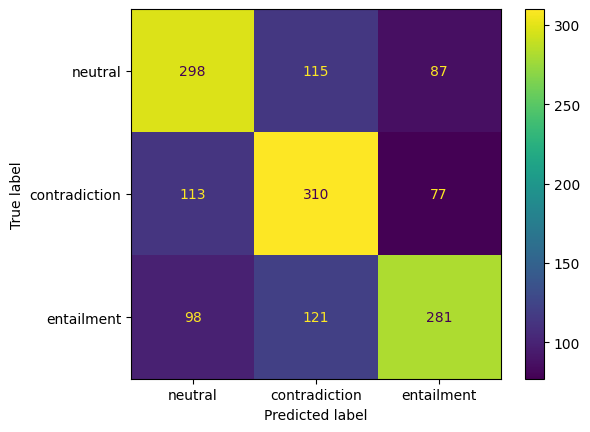

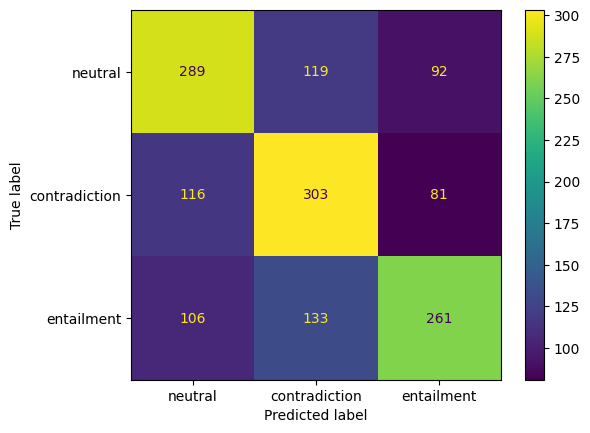

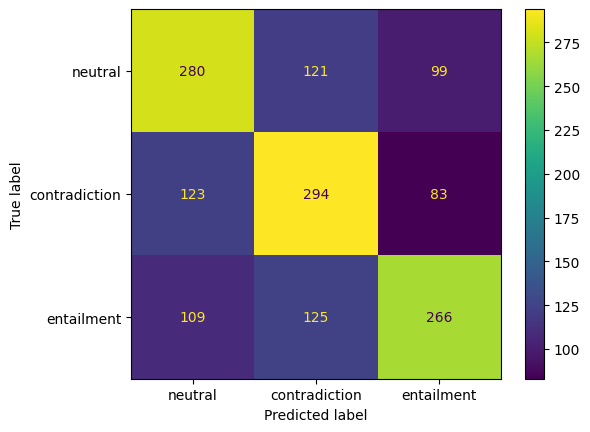

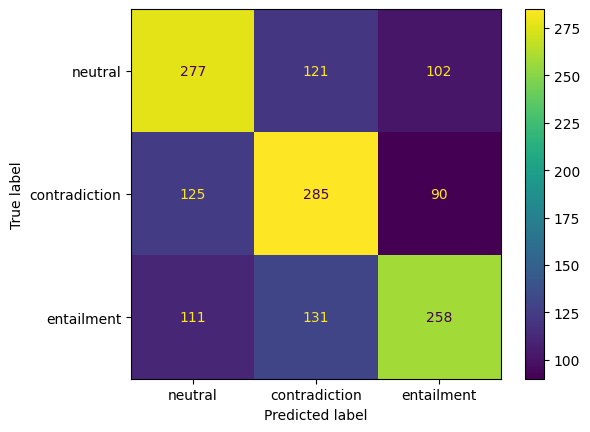

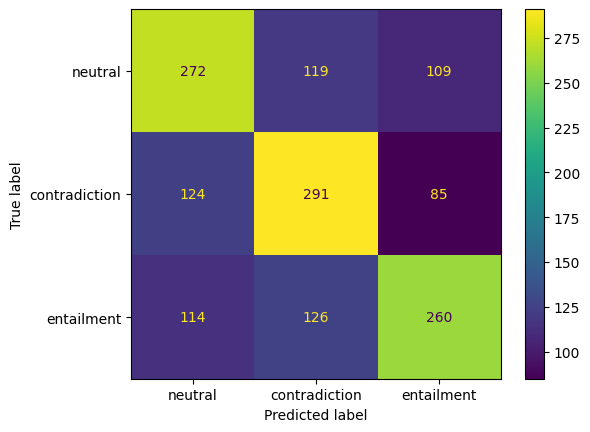

In [ ]:
# training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/experiments_data/model_output",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir="/content/drive/MyDrive/experiments_data/logs",
    learning_rate=2e-5,
    seed=42,
    fp16=True,
)

#pruning configurations --> indices
pruning_configs = {
    "top_layer_pruning": [4, 5],
    "middle_layer_pruning": [2, 3],
    "even_layer_pruning": [0, 2, 4],
    "single_layer_pruning_0": [0],
    "single_layer_pruning_5": [5]
}

#training and evaluating
for name, layers_to_prune in pruning_configs.items():
    print(f"\nPruning and training for {name}...")
    pruned_model = prune_layers(model, layers_to_prune)
    train_and_evaluate_pruned_model(
        model=pruned_model,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        training_args=training_args,
        tokenizer=tokenizer,
        experiment_name=name
    )

